In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import torch
import torch.nn as nn
import heapq
from sklearn.svm import SVR
import deepdish as dd
from sklearn import preprocessing 

/Users/mclinwong/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#inisialize
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")

print(f'Devices: {device}')

Devices: cpu


In [5]:
#read file and load models path
h5path = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/h5/'
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
#read mat file
matpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib/'
figurepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures'
read_temp=scipy.io.loadmat(matpath + 'data2_test.mat')
S_est=read_temp['S_est']
S_est = S_est.transpose(0, 2, 1)
[r2,K,I] = np.shape(S_est)

S_real = np.zeros((r2, 1, I))
S_imag = np.zeros((r2, 1, I))
S_real[:,0,:] = S_est[:,0,:]
S_imag[:,0,:] = S_est[:,1,:]
S_abs = np.append(S_real, S_imag, axis=2)
S_abs = np.squeeze(S_abs)
S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']
gamma=read_temp['gamma']
gamma_R=read_temp['gamma_R']
S_label1 = np.expand_dims(S_label, 2)
normalizer = preprocessing.Normalizer().fit(R_est)

[r2,c]=np.shape(R_est)
[r2,I]=np.shape(S_label)
print(f'r2: {r2}, I: {I}, c: {c}, K: {K}')
print(np.shape(S_est))
print(np.shape(S_real))
print(np.shape(S_abs))

print(np.shape(S_abs)[0])

r2: 5, I: 120, c: 56, K: 2
(5, 2, 120)
(5, 1, 120)
(5, 240)
5


In [73]:
class CNN(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), nn.BatchNorm1d(12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7),  nn.BatchNorm1d(6), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), nn.BatchNorm1d(3), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1),nn.BatchNorm1d(1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out
cnnrelu = torch.load(pthpath + 'cnnrelu.pth')
cnntanh = torch.load(pthpath + 'cnntanh.pth')
cnnsigmoid = torch.load(pthpath + 'cnnsigmoid.pth')


In [74]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN_nobatchnorm(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out

cnnrelu_nobatchnorm = torch.load(pthpath + 'cnnrelu_nobatchnorm.pth')
cnntanh_nobatchnorm = torch.load(pthpath + 'cnntanh_nobatchnorm.pth')
cnnsigmoid_nobatchnorm = torch.load(pthpath + 'cnnsigmoid_nobatchnorm.pth')

In [75]:
class DNN(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*I, int(2*I/3)), nn.BatchNorm1d(int(2*I/3)), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*I/3), int(4*I/9)), nn.BatchNorm1d(int(4*I/9)), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*I/9), int(2*I/3)), nn.BatchNorm1d(int(2*I/3)), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*I/3), I), nn.BatchNorm1d(I), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
dnnrelu = torch.load(pthpath + 'dnnrelu.pth')
dnntanh = torch.load(pthpath + 'dnntanh.pth')
dnnsigmoid = torch.load(pthpath + 'dnnsigmoid.pth')

In [76]:
class DNN_nobatchnorm(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*L, int(2*L/3)), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*L/3), int(4*L/9)), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*L/9), int(2*L/3)), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*L/3), L), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
    
dnnrelu_nobatchnorm = torch.load(pthpath + 'dnnrelu_nobatchnorm.pth')
dnntanh_nobatchnorm = torch.load(pthpath + 'dnntanh_nobatchnorm.pth')
dnnsigmoid_nobatchnorm = torch.load(pthpath + 'dnnsigmoid_nobatchnorm.pth')

In [77]:
def Test(model, inputx, flag=1):
    model = model.to(device)
    model.eval()
    ls = []
    for i in range(r2):
        with torch.no_grad():
            if flag == 0:
                x = np.zeros((K, I))
                x[:, :] = inputx[i, :, :]
                #atttntion: the input of the model should be a tensor which is in the shape of (batch_size, channel, length)
                x = torch.from_numpy(x.reshape(1, K, I)).float().to('cpu')
            elif flag == 1:
                x = np.zeros(K*I)
                x[:] = inputx[i, :]
                x = torch.from_numpy(x.reshape(1, -1)).float().to('cpu')
            x = x.to(device)
            # print(np.shape(x))
            y = model(x)
            y = y.cpu().numpy()
            ls.append(y)
    predict = np.array(ls)
    return predict

In [87]:

predict_dnnrelu = np.squeeze(Test(dnnrelu, S_abs))
predict_dnntanh = np.squeeze(Test(dnntanh, S_abs))
predict_cnnrelu = np.squeeze(Test(cnnrelu, S_est, flag=0))
predict_cnnrelu_nobatchnorm = np.squeeze(Test(cnnrelu_nobatchnorm, S_est, flag=0))
predict_cnntanh = np.squeeze(Test(cnntanh, S_est, flag=0))
    


In [79]:
# print(R_est)
print(np.shape(predict_cnnrelu))

(5, 120)


In [80]:
# DOA_plot = [50 ,160 ,320]

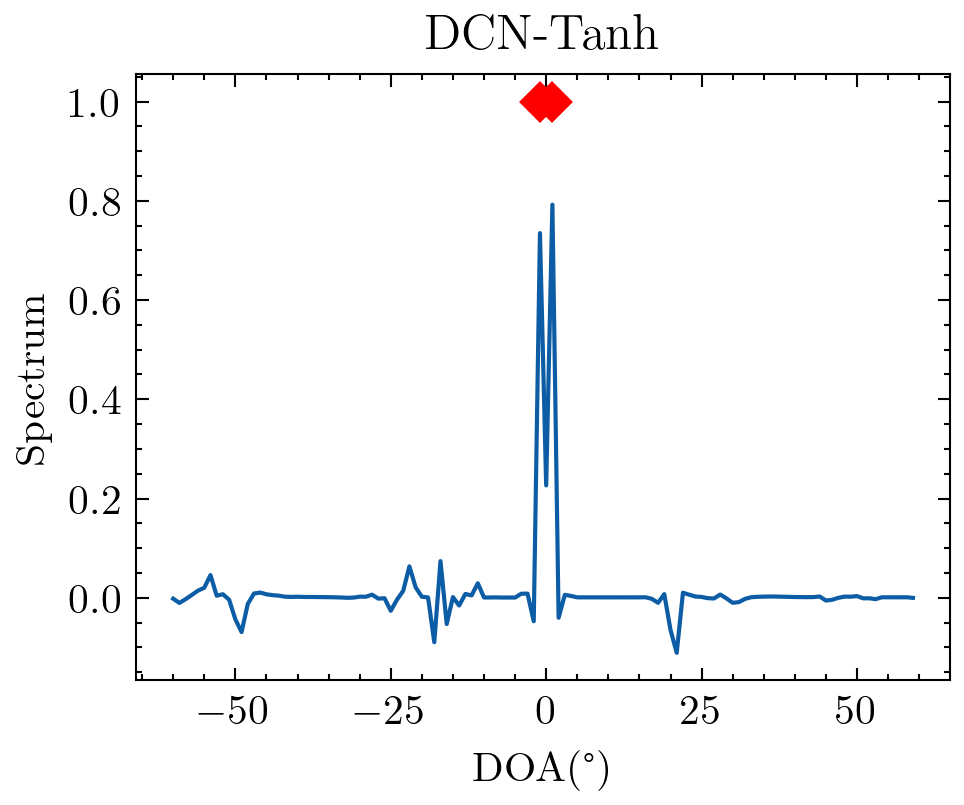

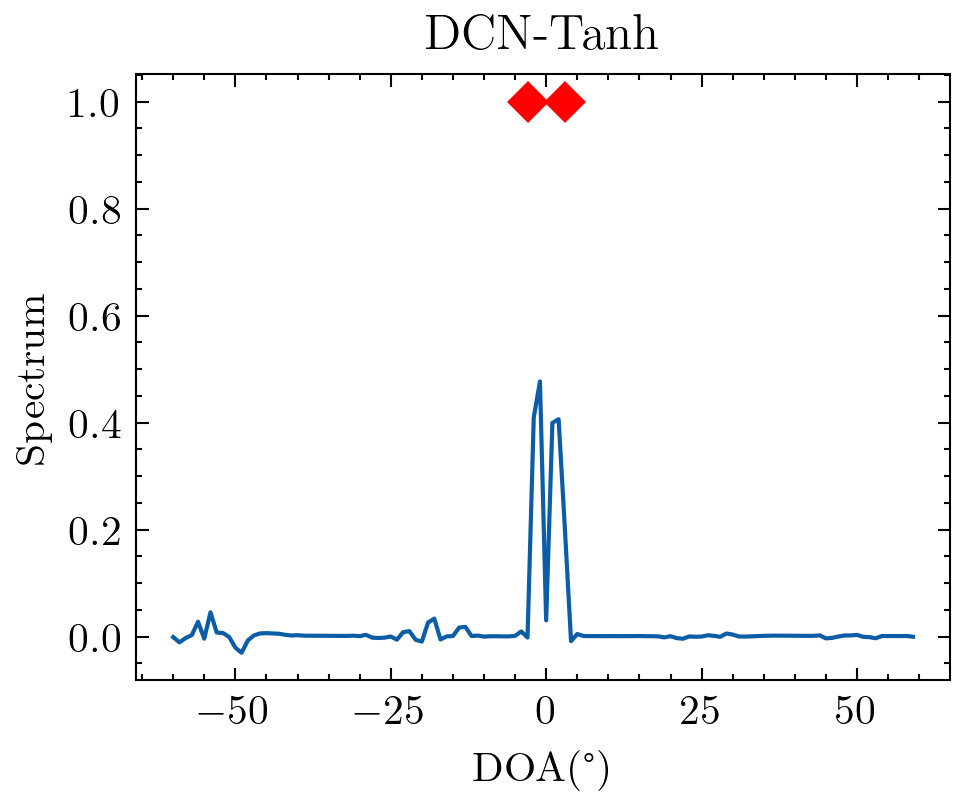

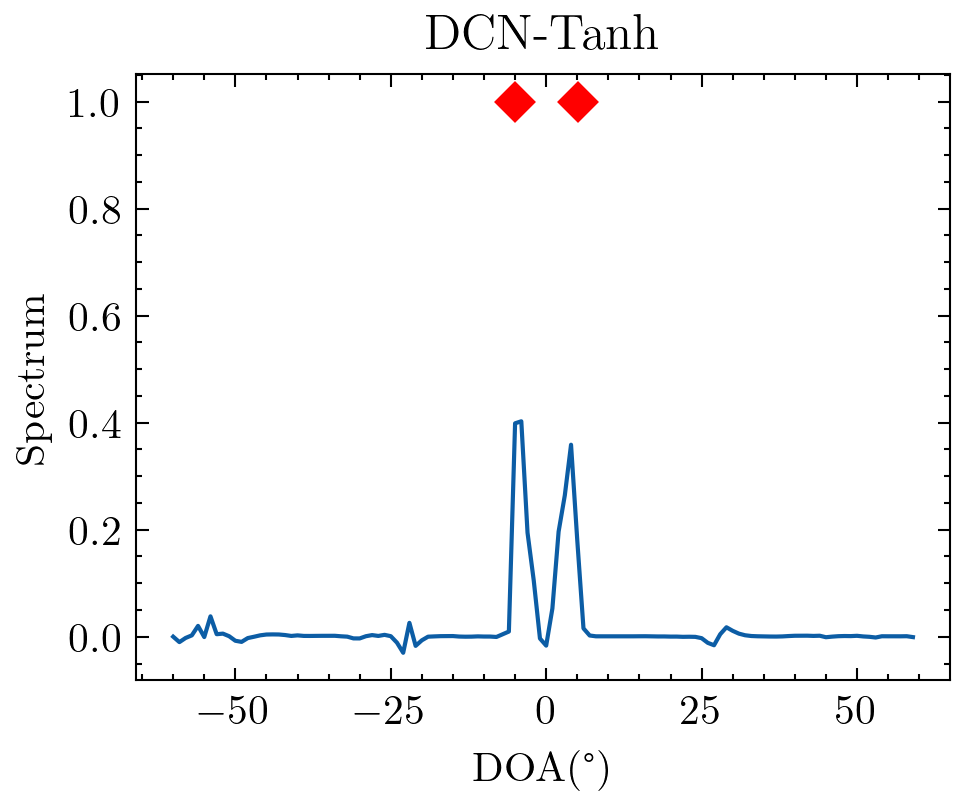

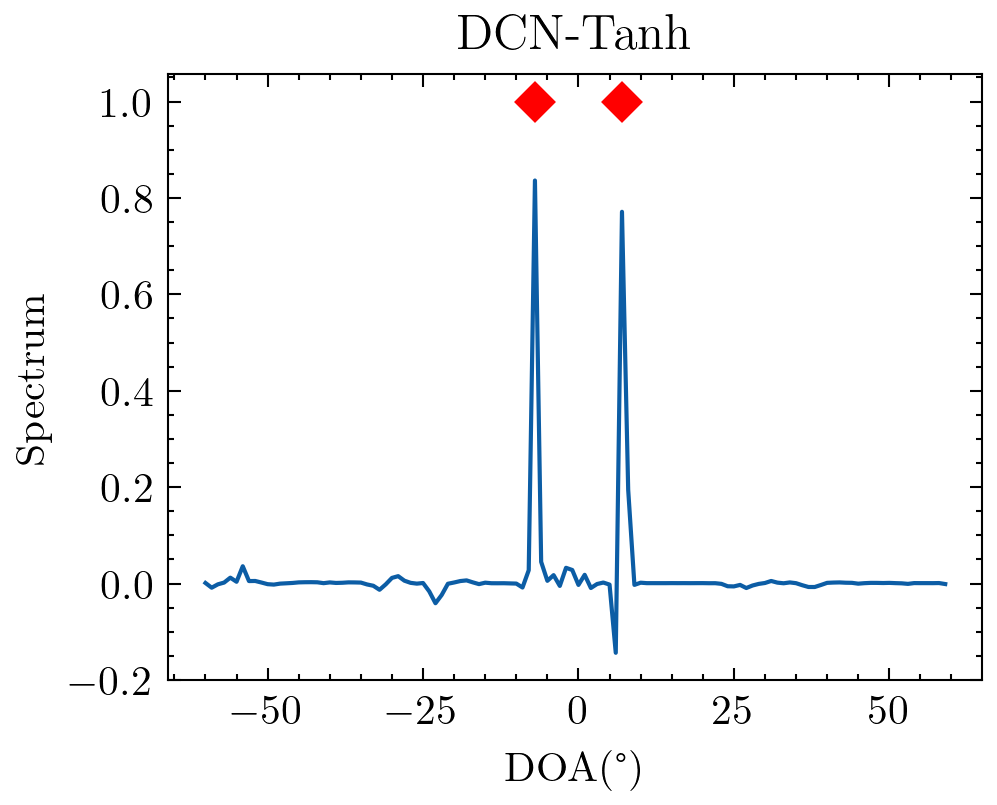

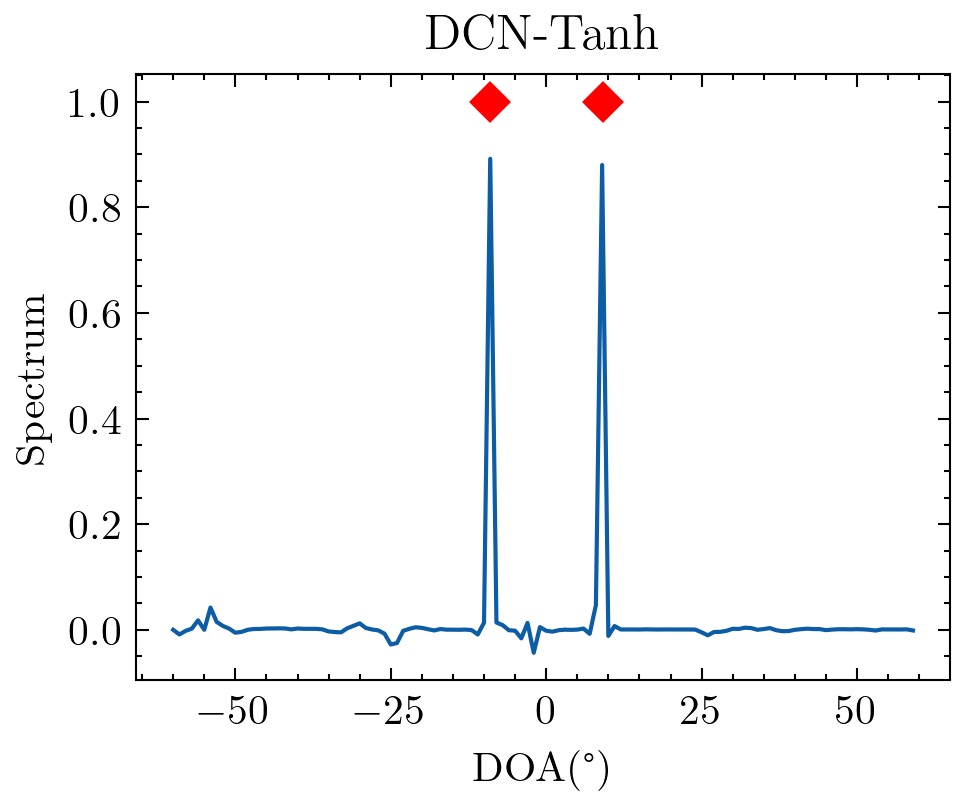

In [81]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_cnntanh[i, :]
        plt.figure()
        plt.title('DCN-Tanh')
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DCN_Tanh/DOA'+str(i)+'.pdf')
        plt.show()

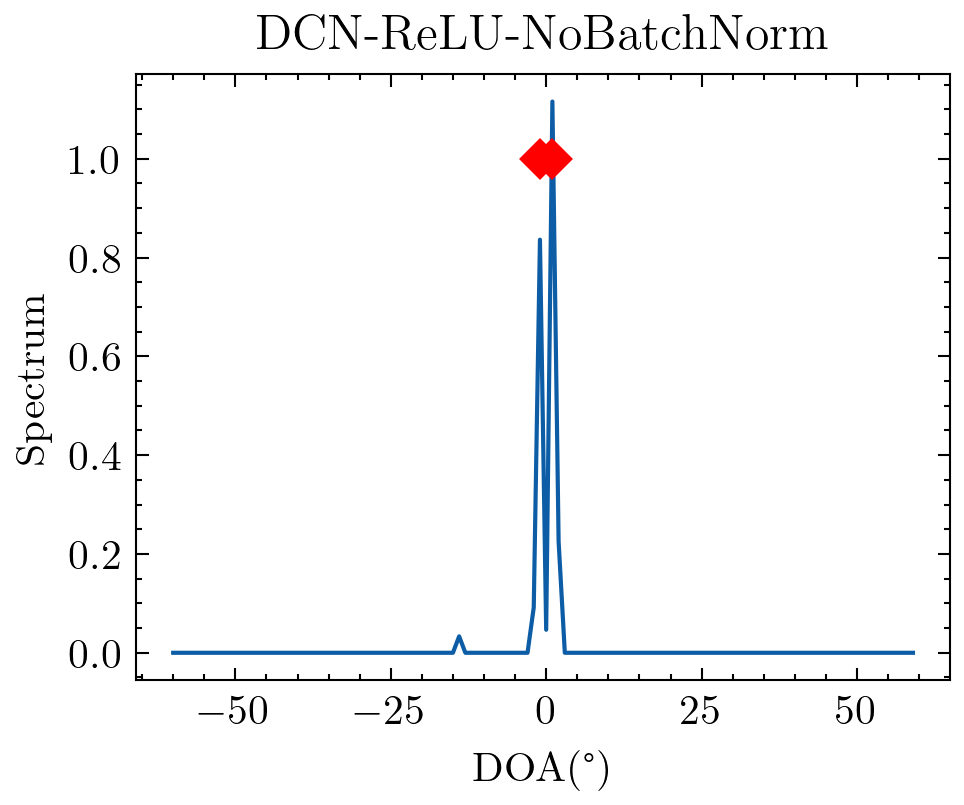

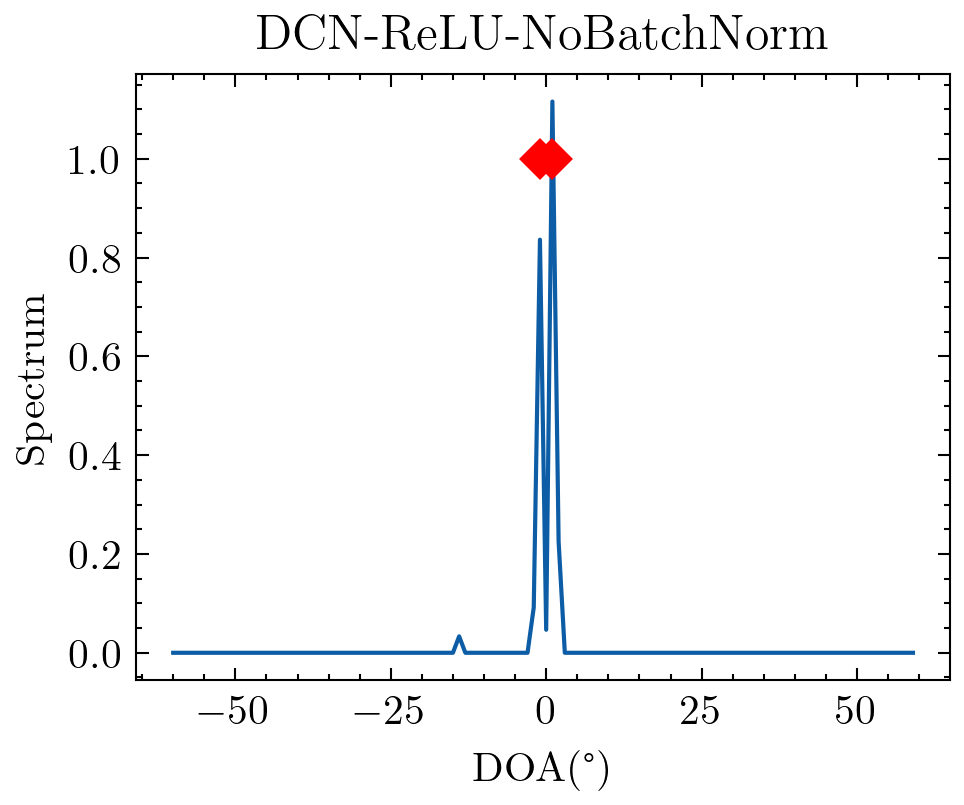

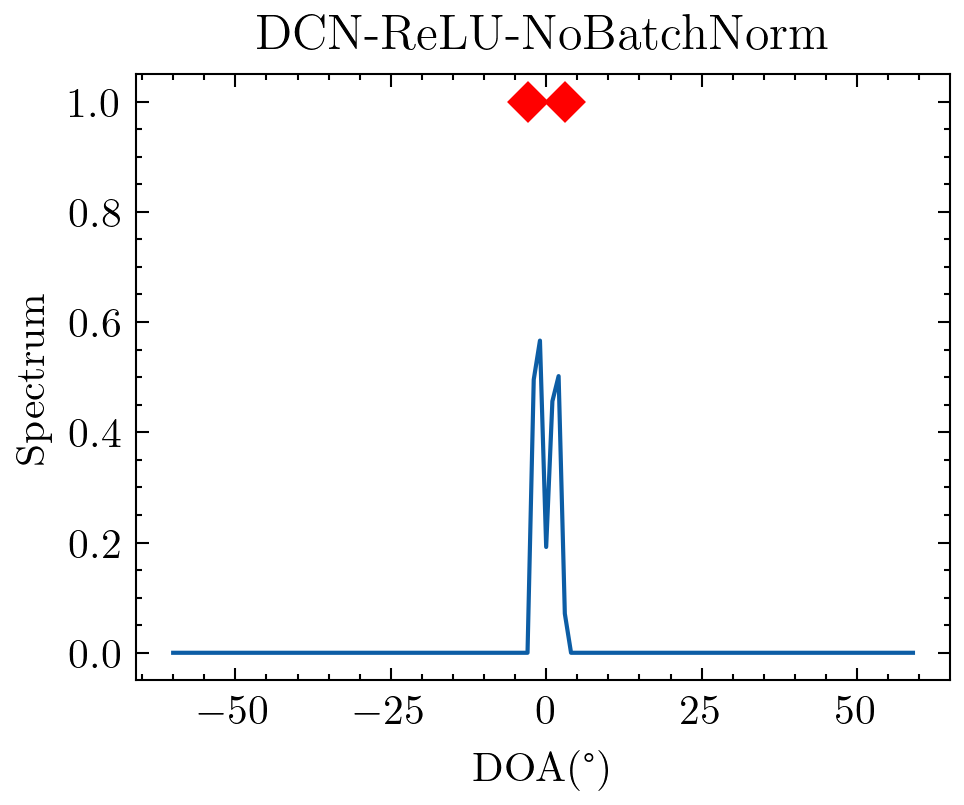

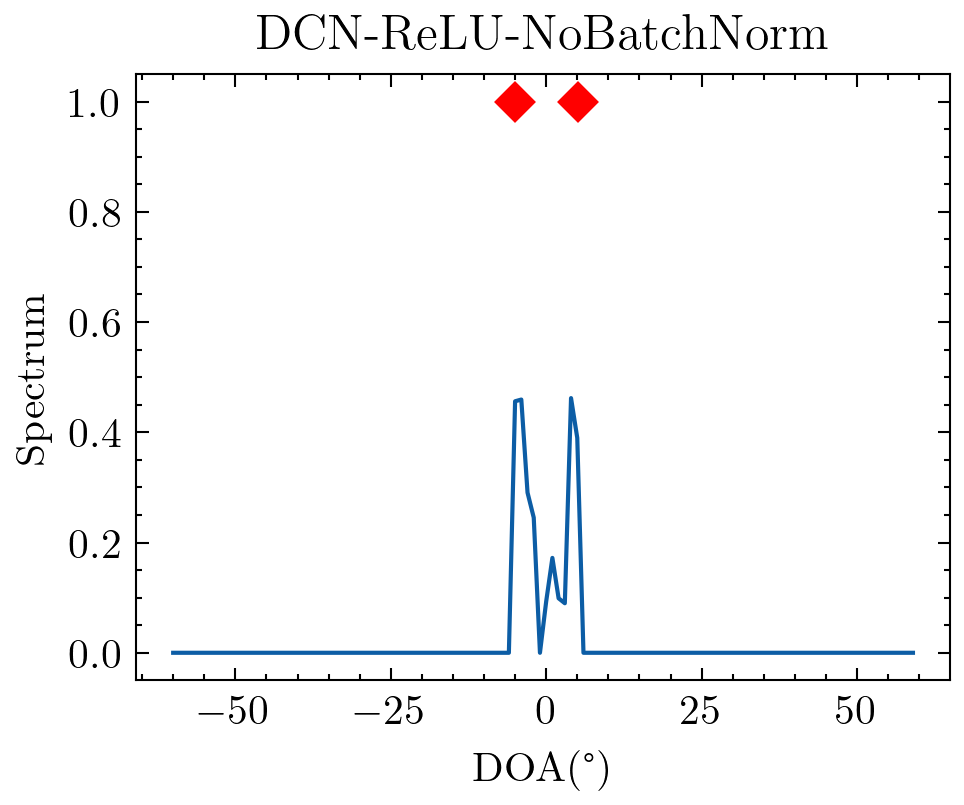

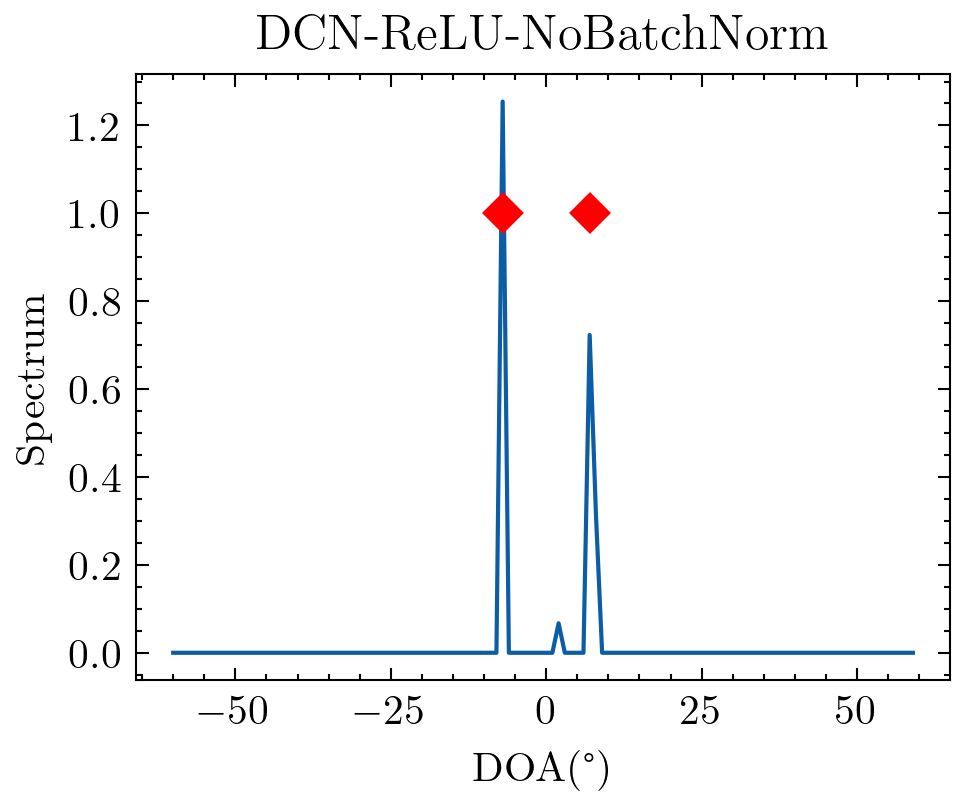

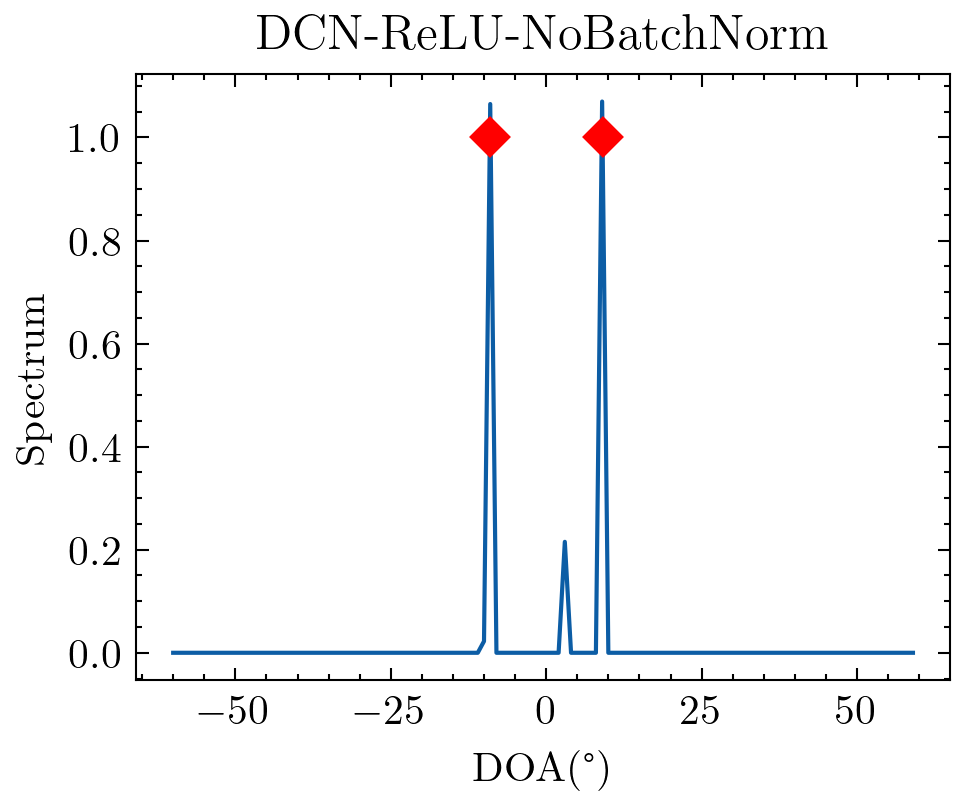

In [89]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_cnnrelu_nobatchnorm[i, :]
        plt.figure()
        plt.title('DCN-ReLU-NoBatchNorm')
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DCN_ReLU_Nobatchnorm/DOA'+str(i)+'.pdf')
        plt.show()

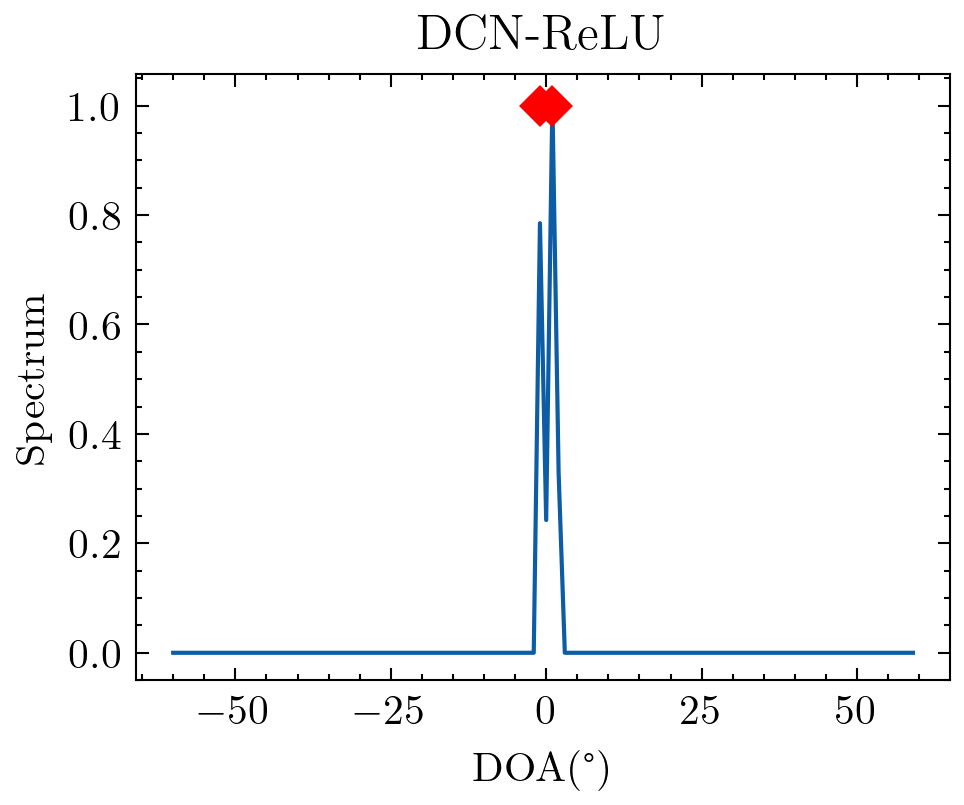

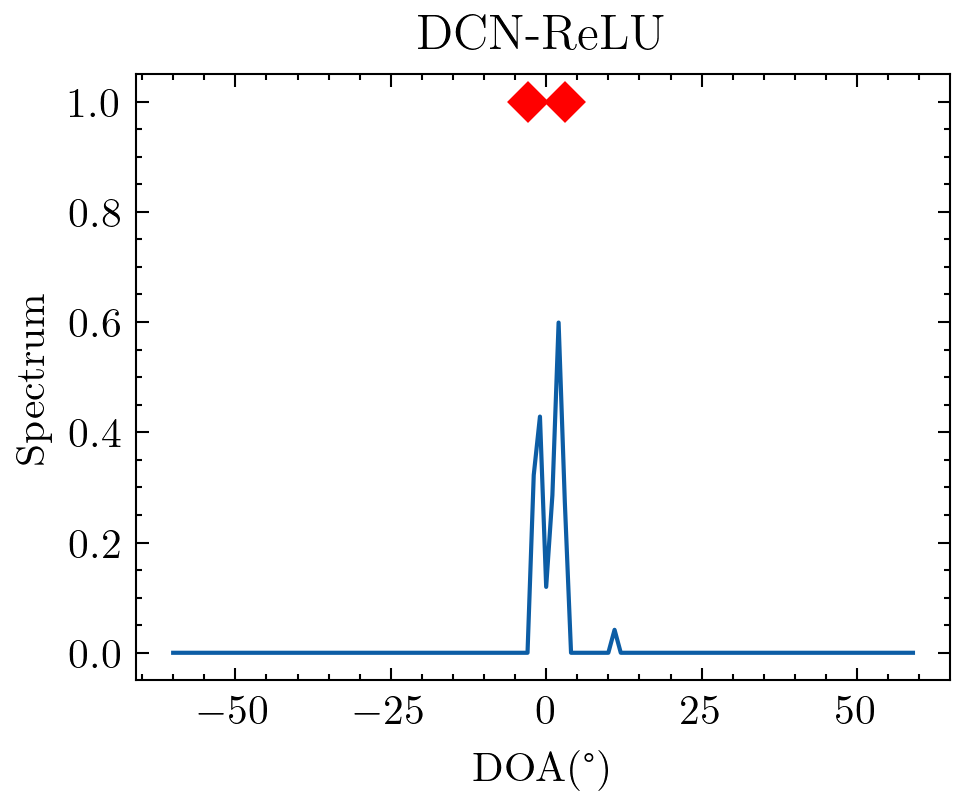

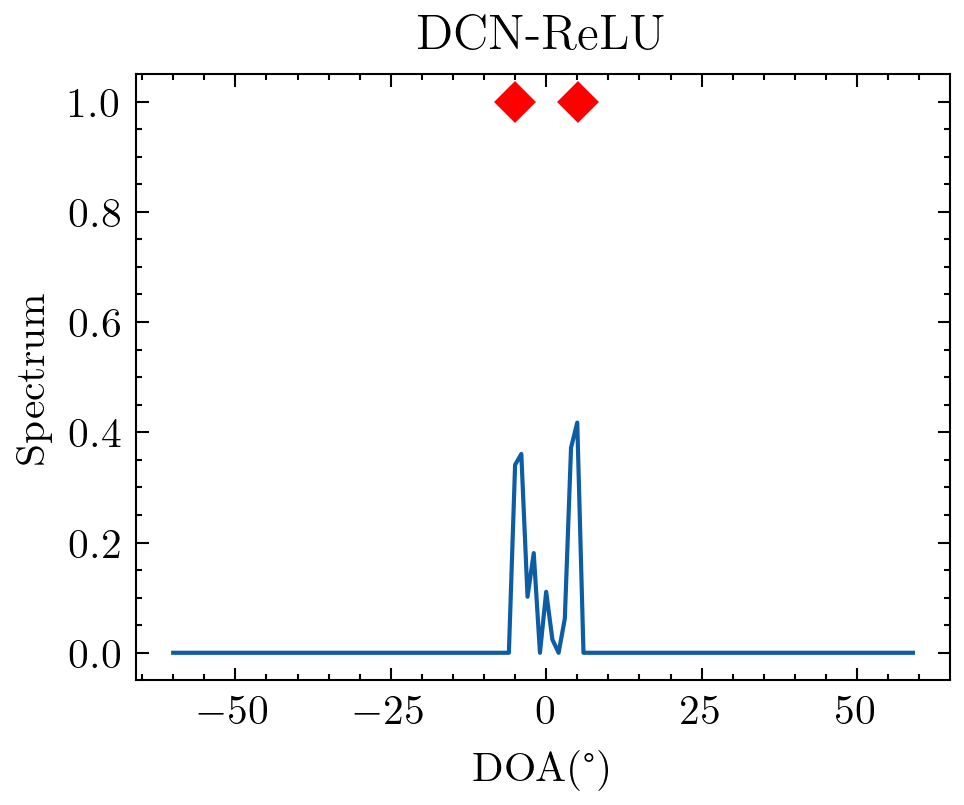

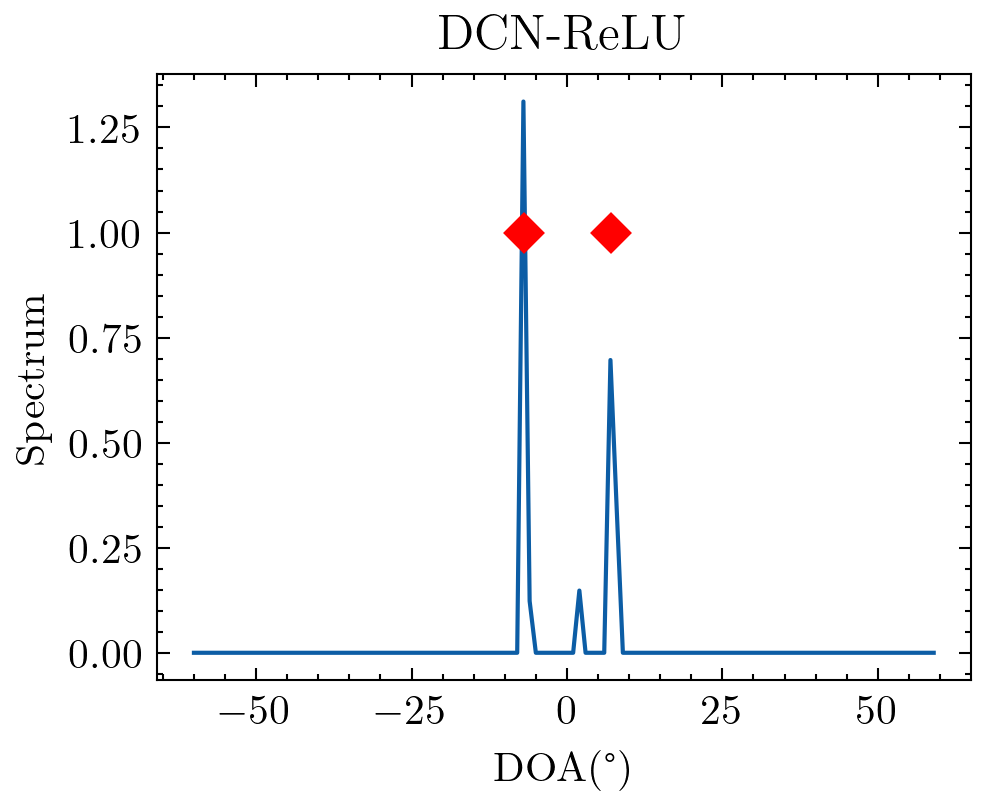

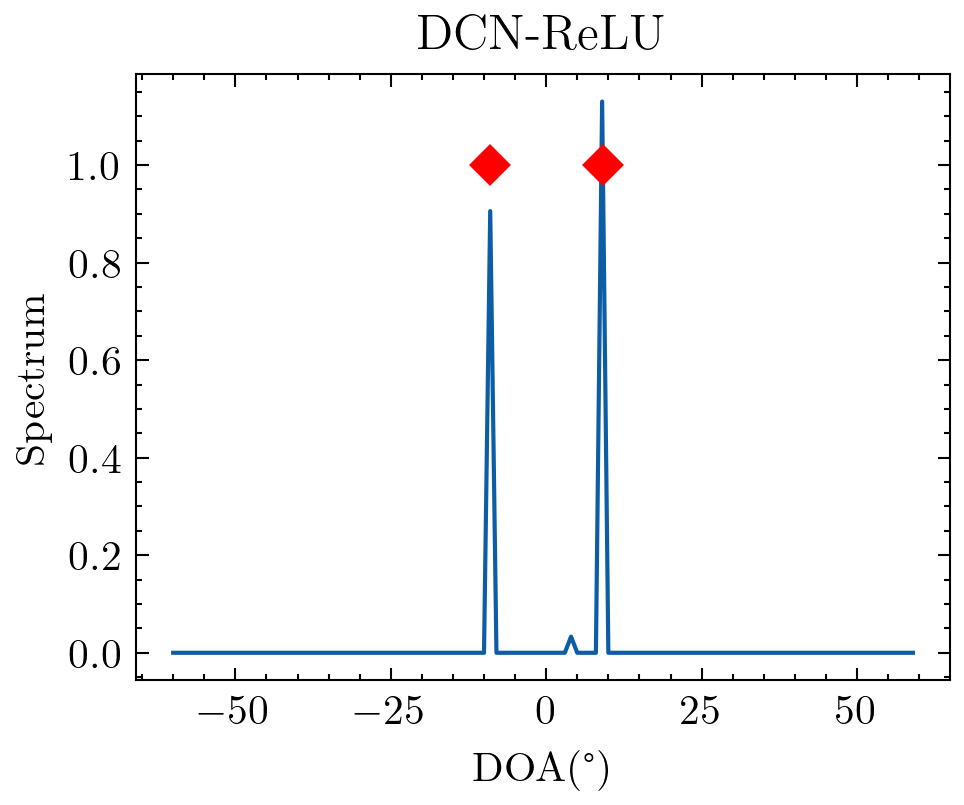

In [82]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_cnnrelu[i, :]
        plt.figure()
        plt.title('DCN-ReLU')
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DCN_ReLU/DOA'+str(i)+'.pdf')
        plt.show()

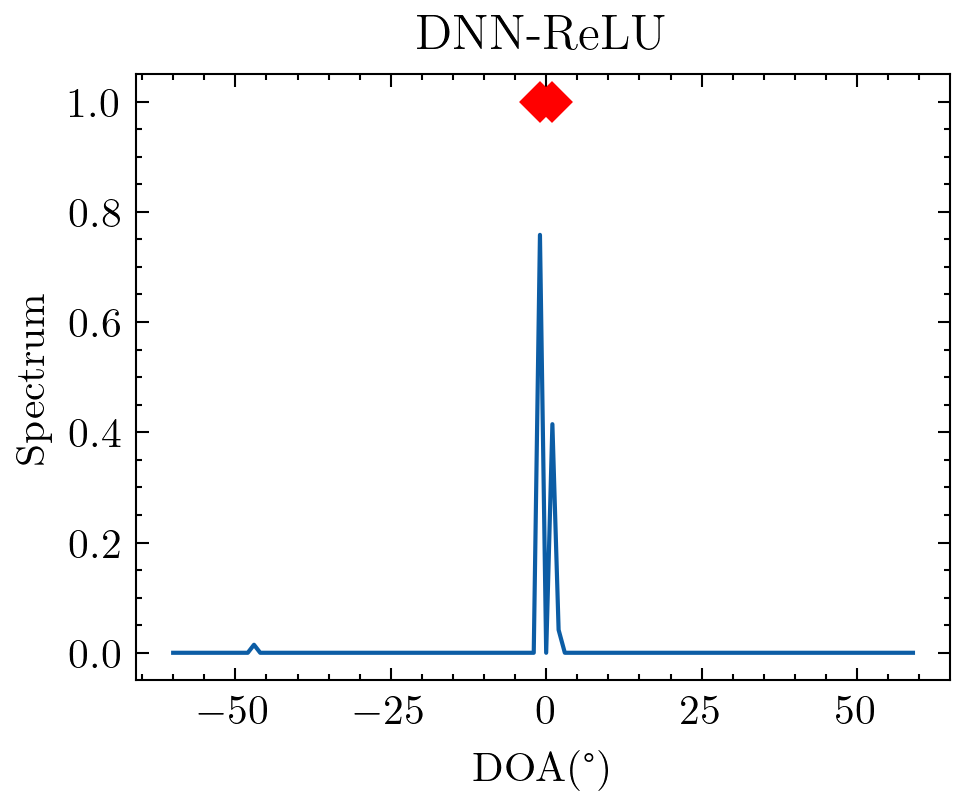

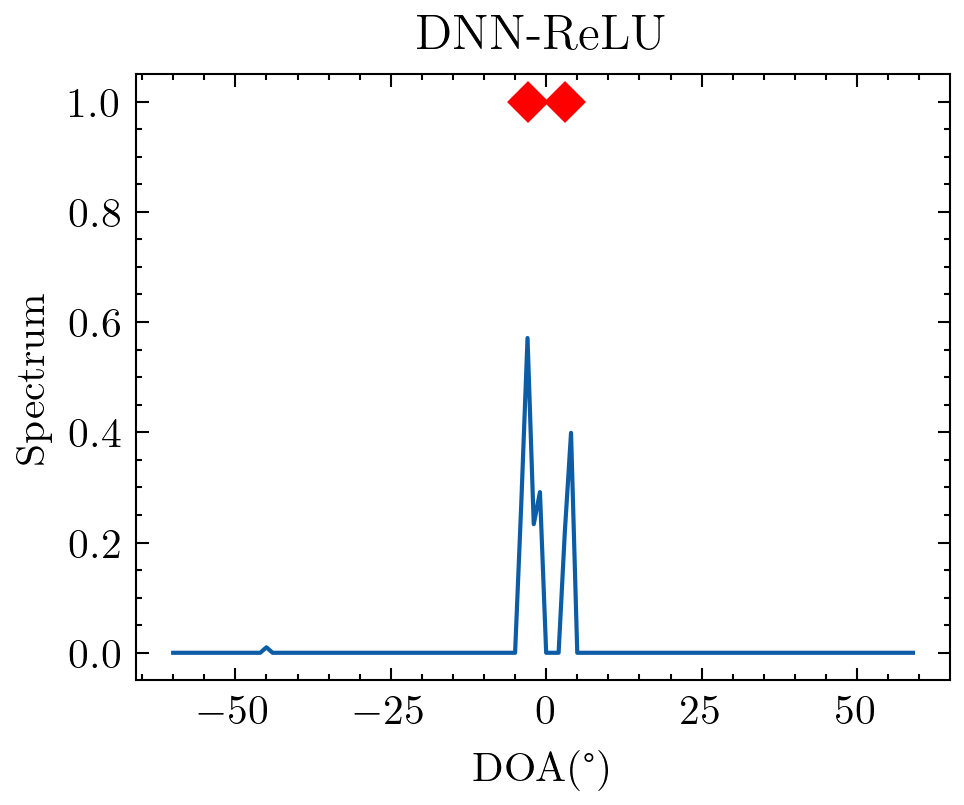

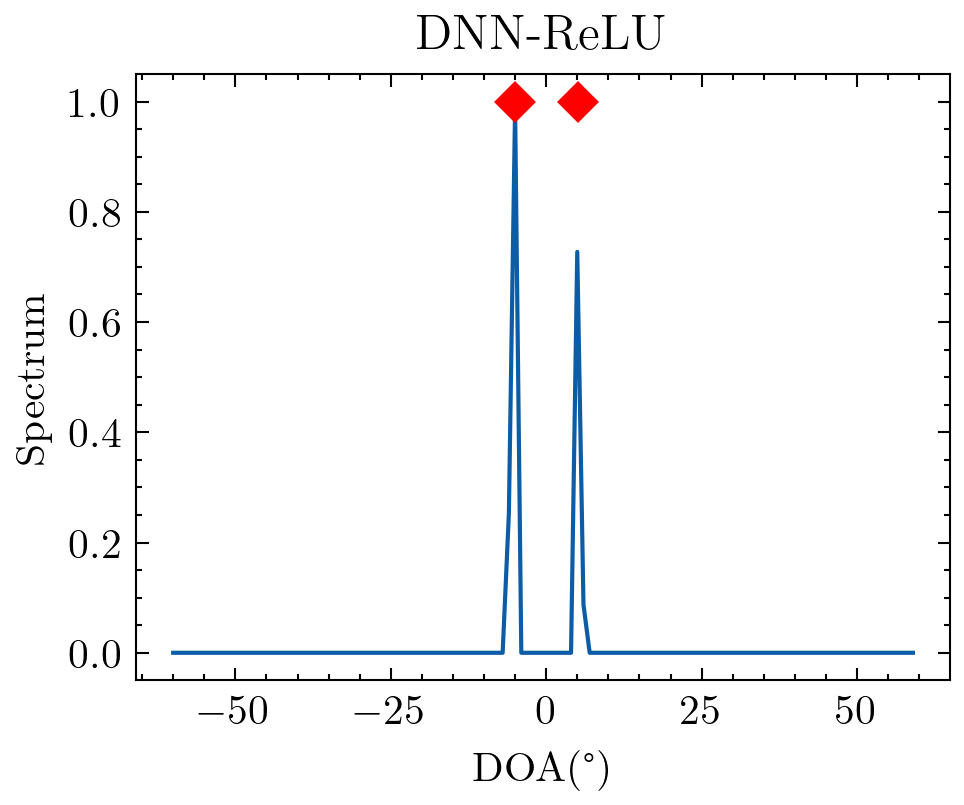

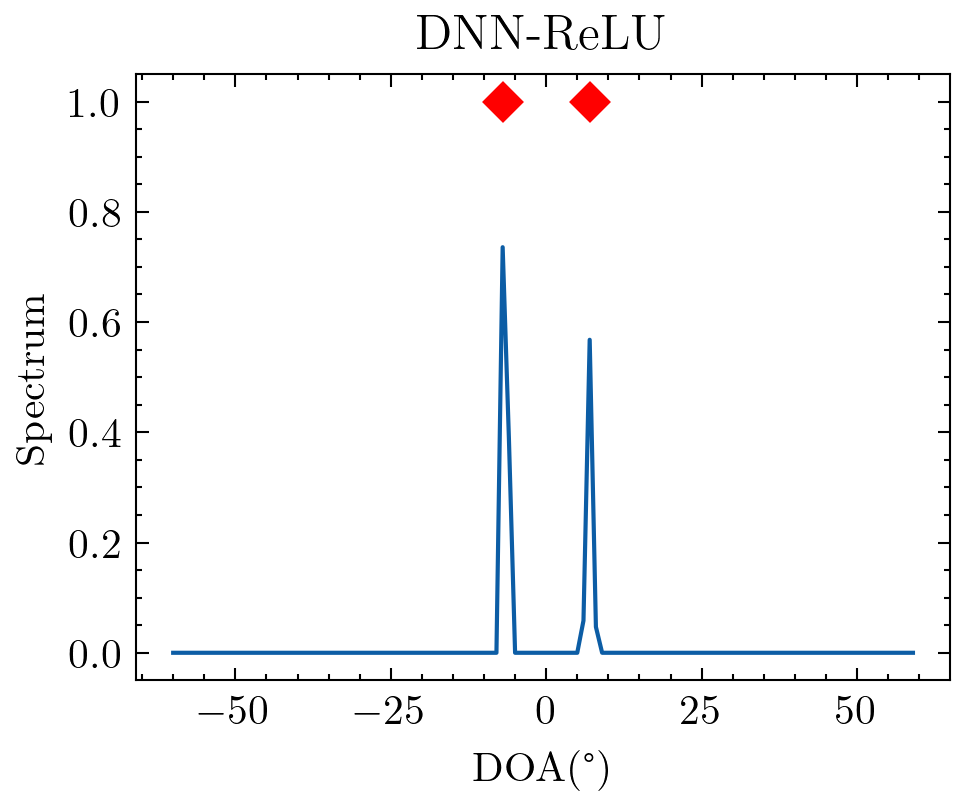

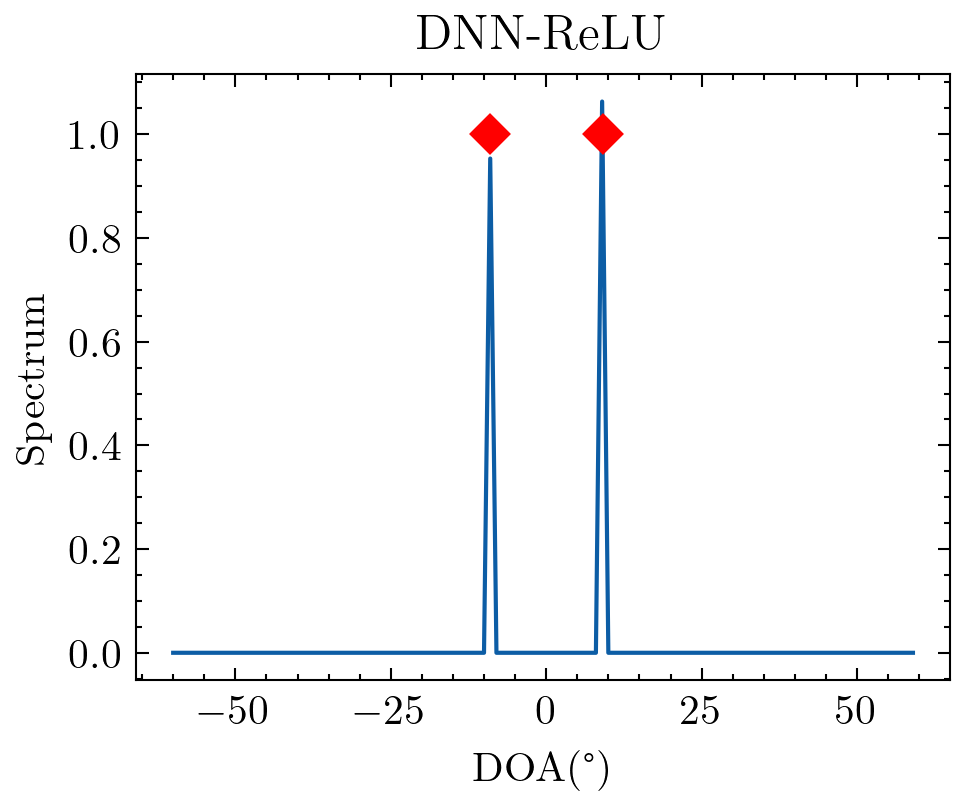

In [83]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_dnnrelu[i, :]
        plt.figure()
        plt.title('DNN-ReLU')
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DNN_ReLU/DOA'+str(i)+'.pdf')
        plt.show()

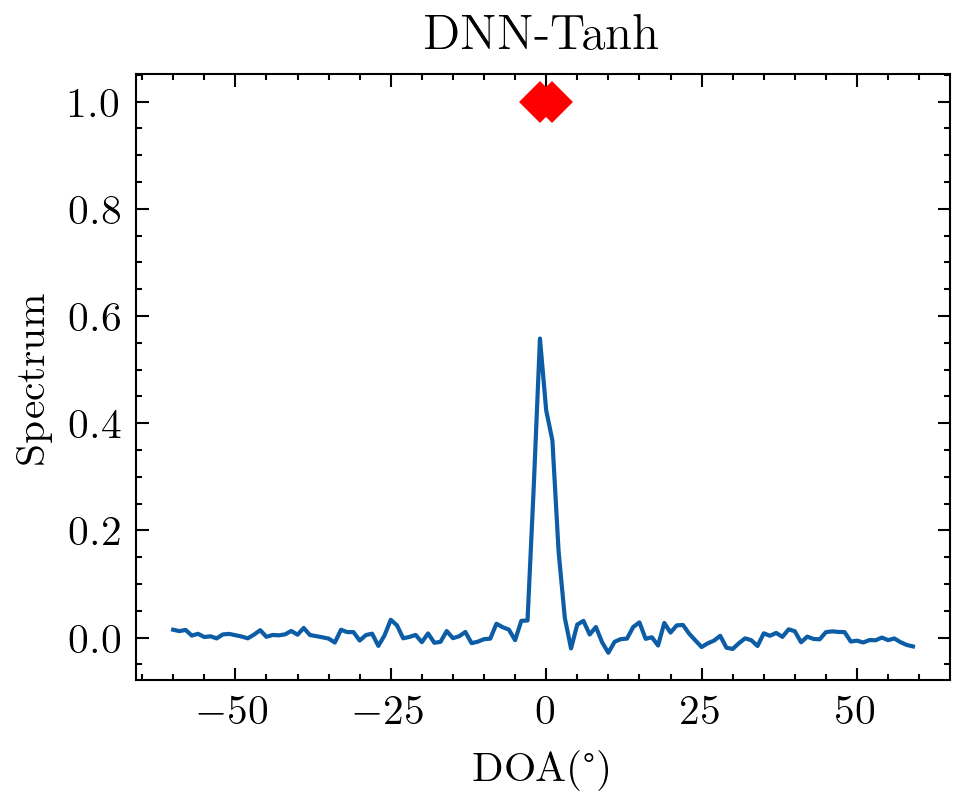

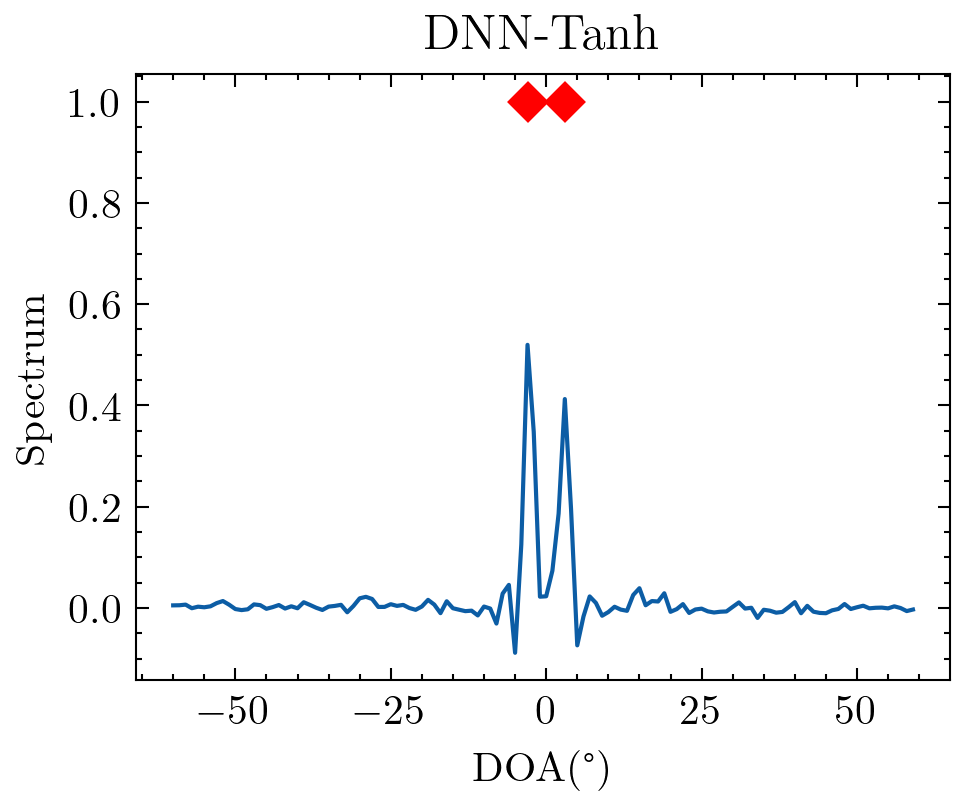

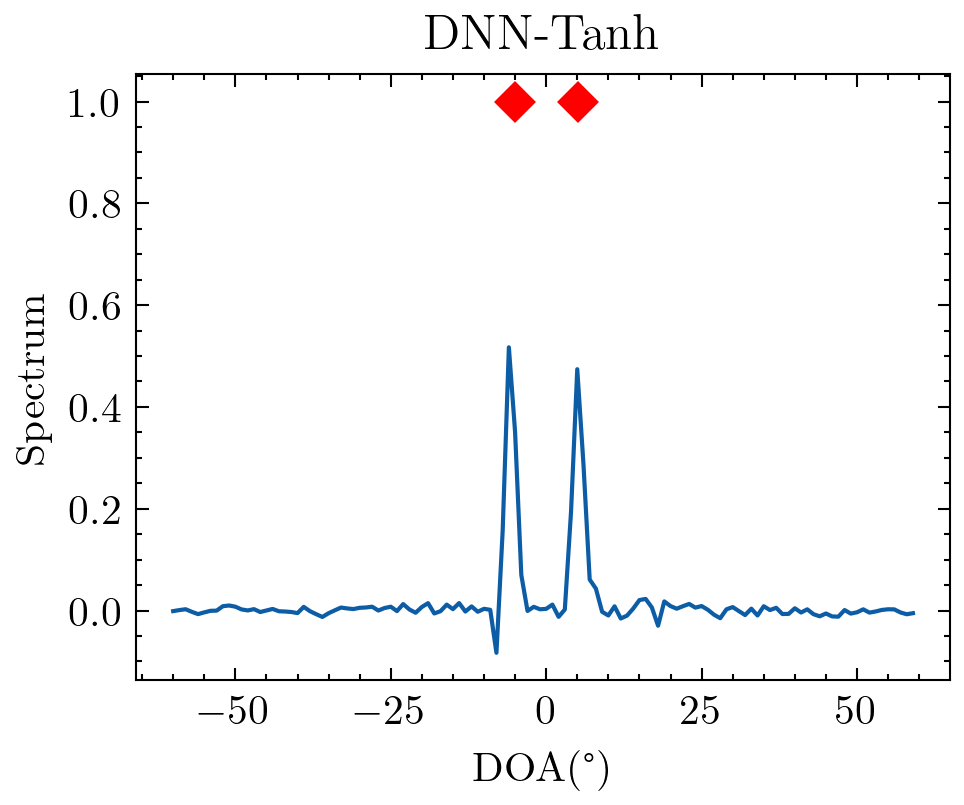

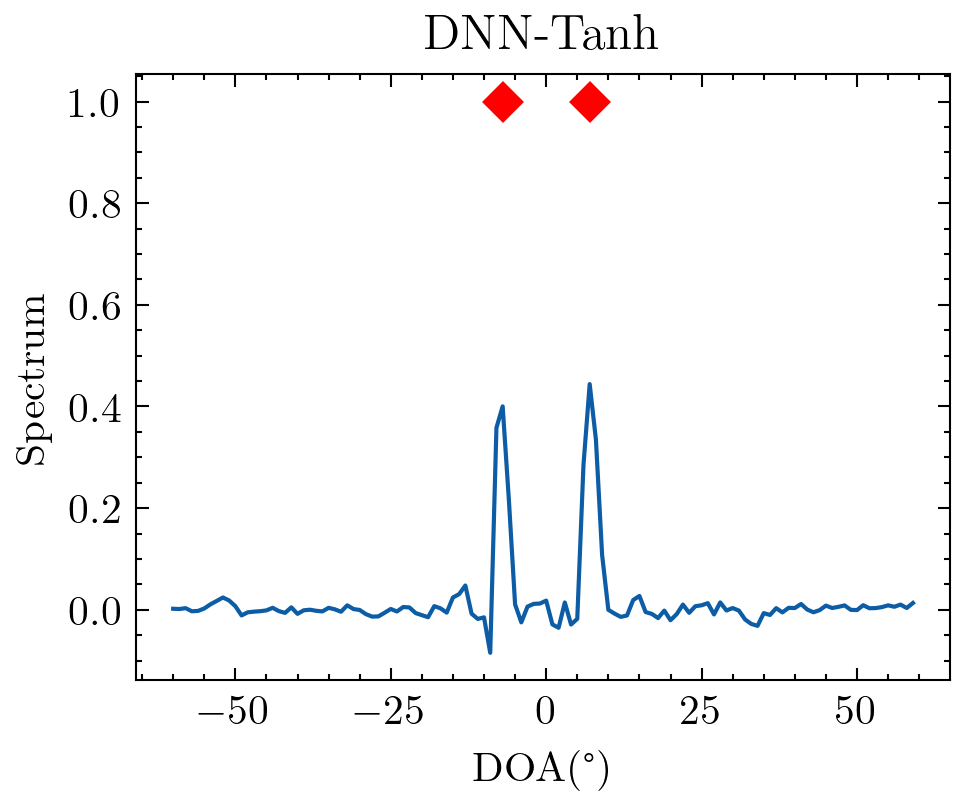

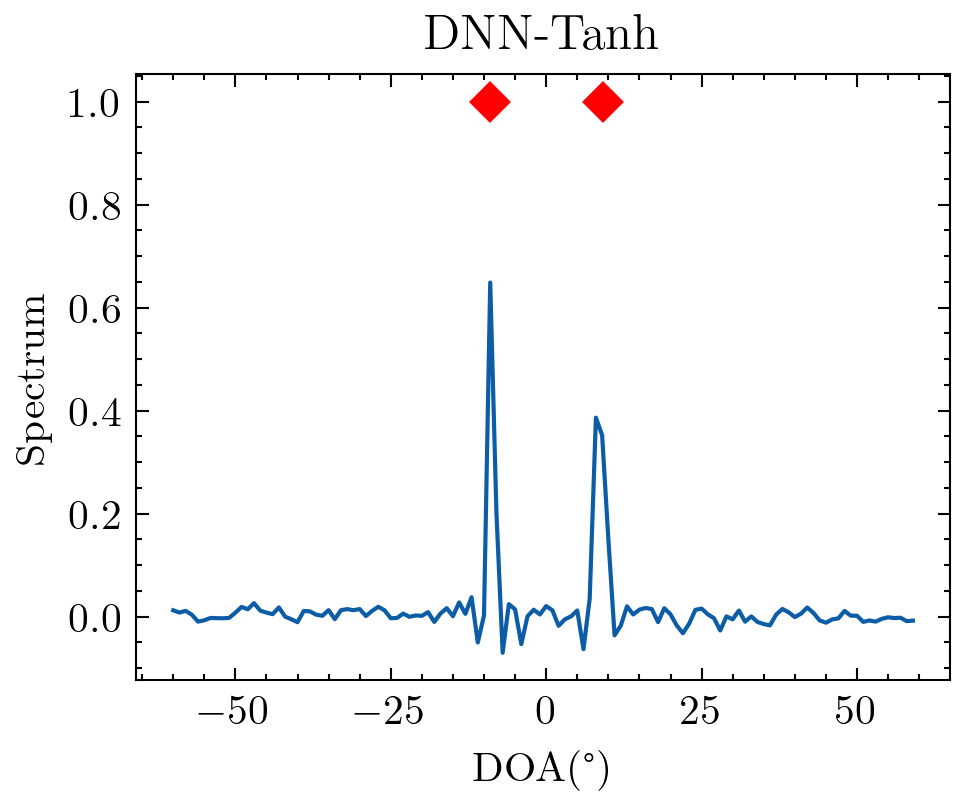

In [84]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_dnntanh[i, :]
        plt.figure()
        plt.title('DNN-Tanh')
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DNN_Tanh/DOA'+str(i)+'.pdf')
        plt.show()

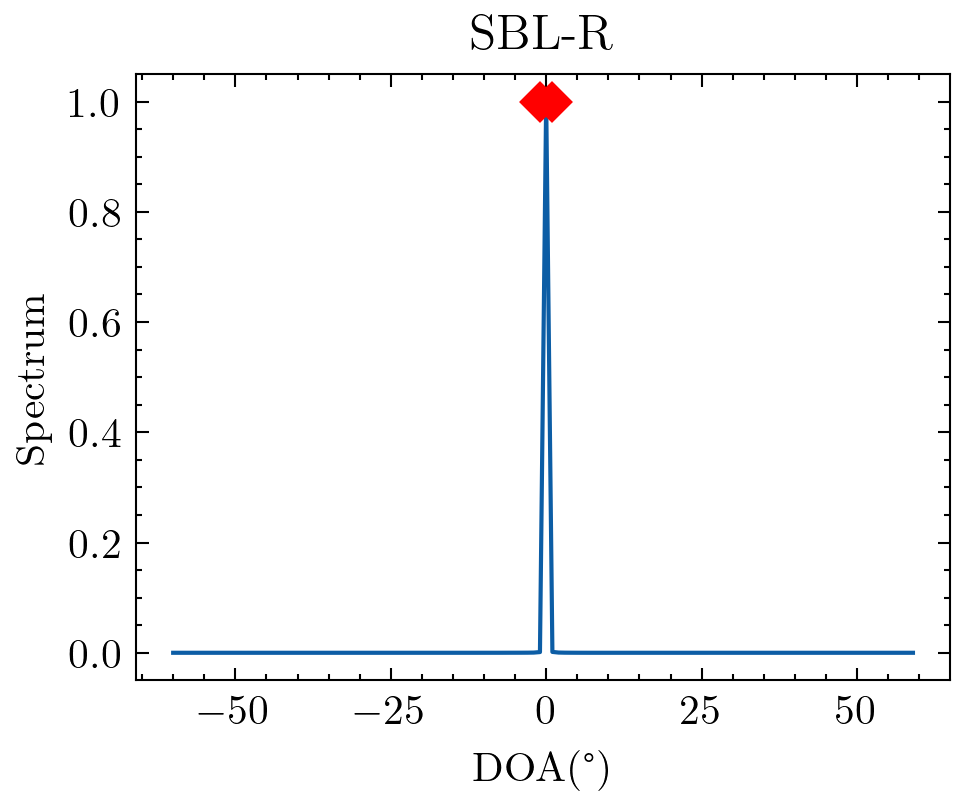

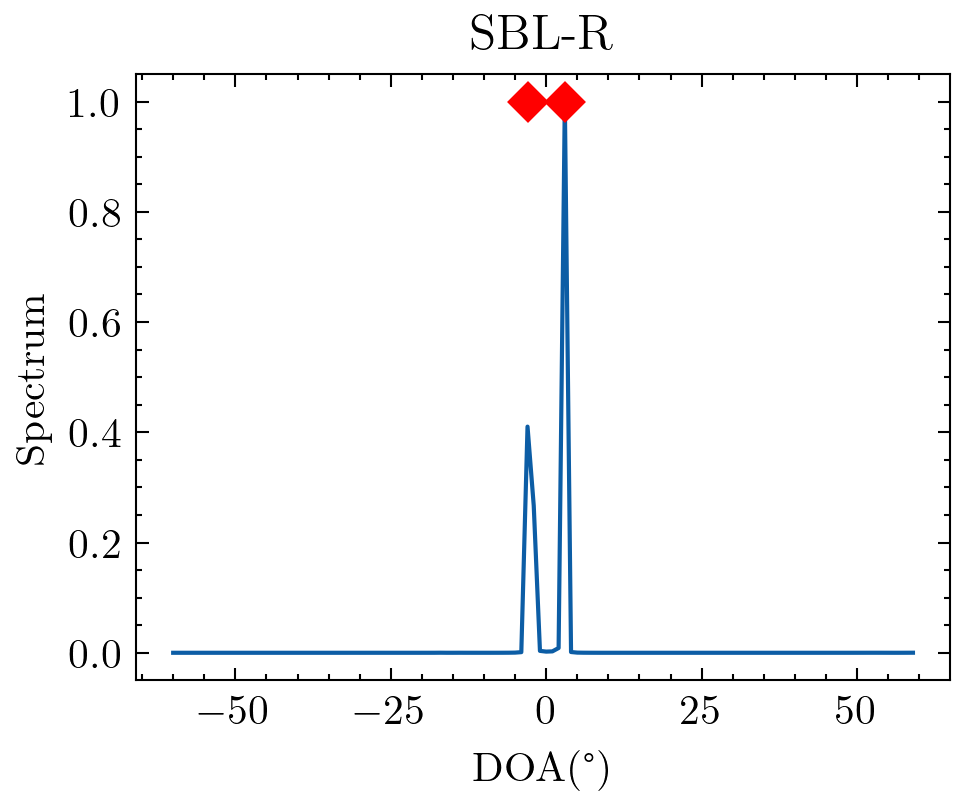

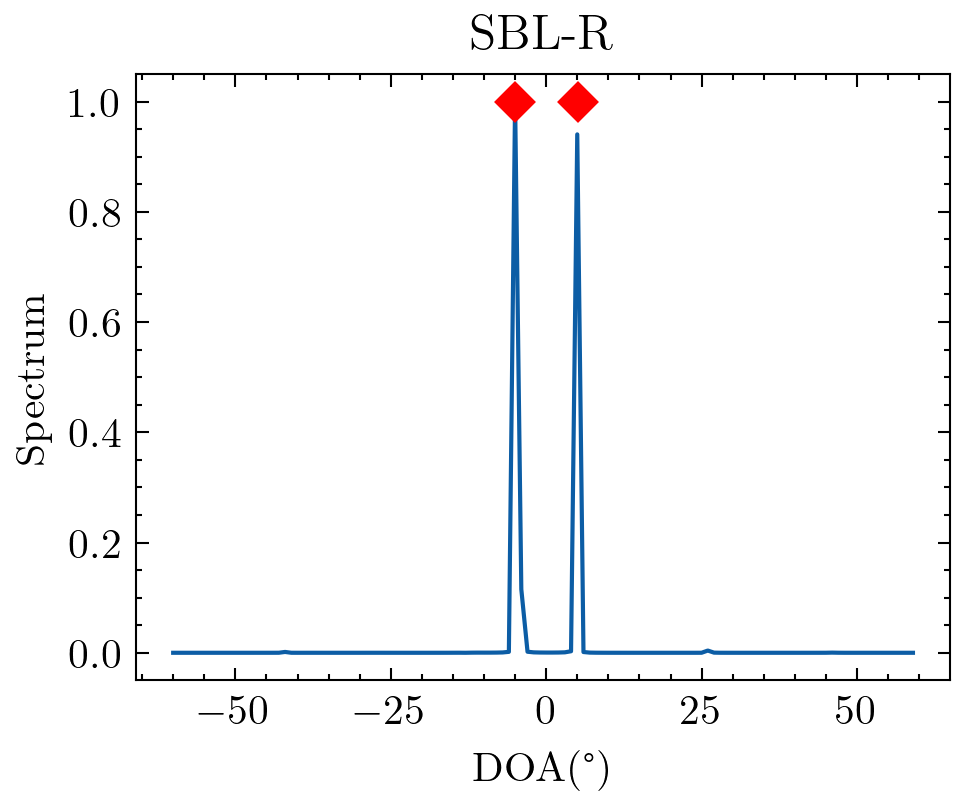

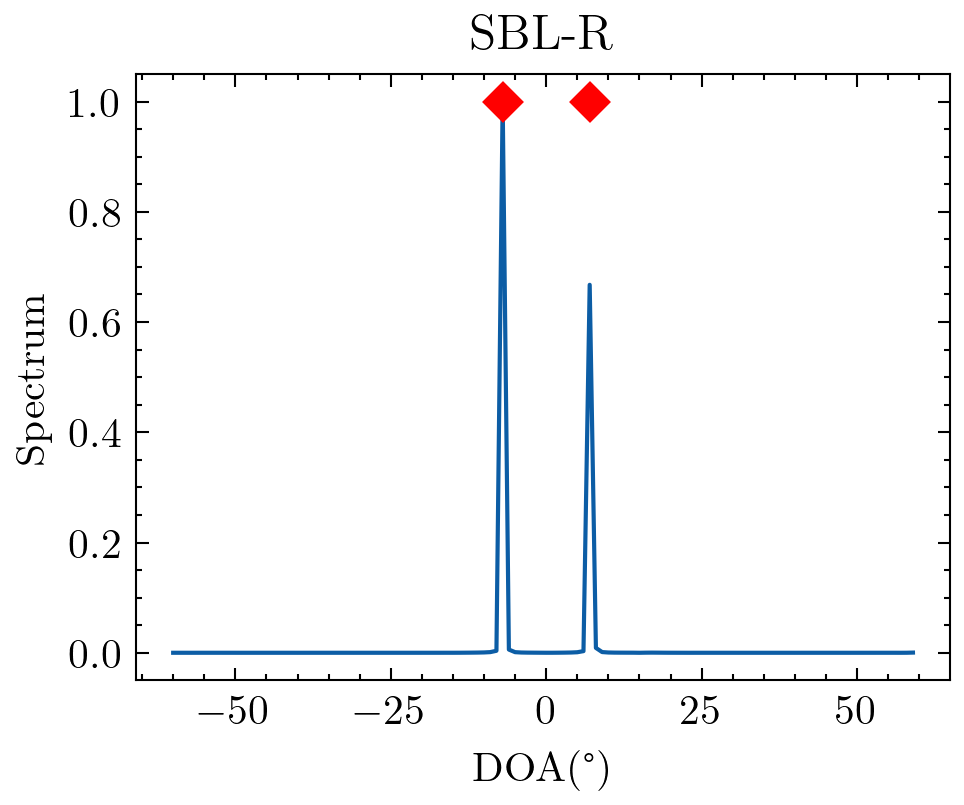

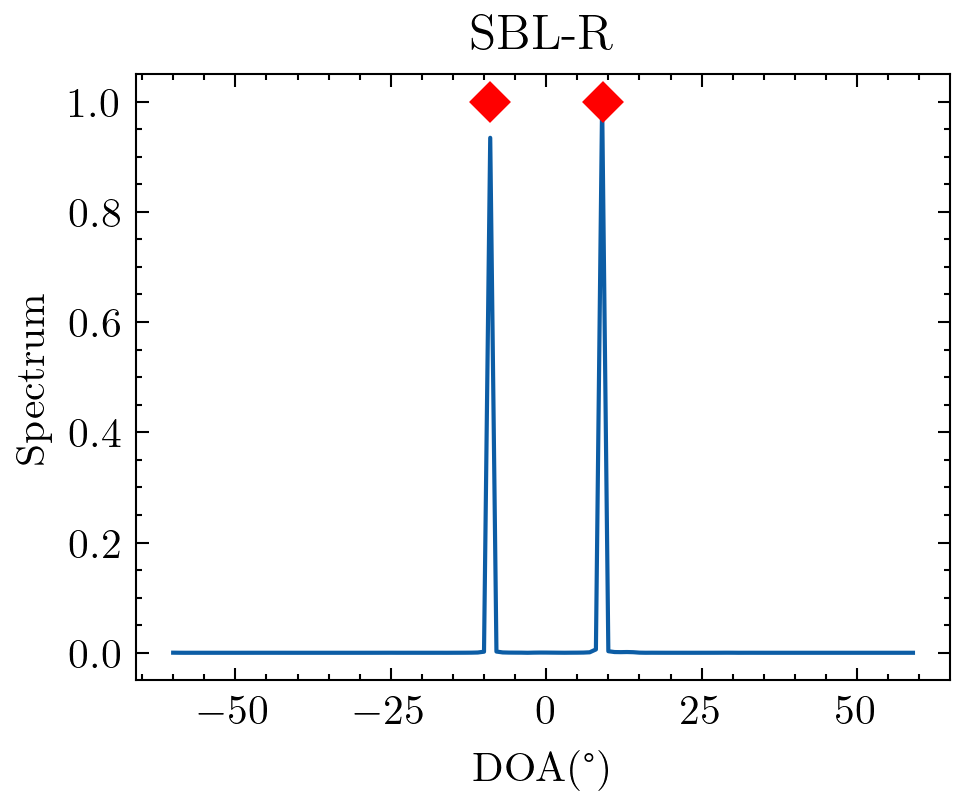

In [85]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = gamma_R[i,:]/max(gamma_R[i,:])
        plt.figure()
        plt.title('SBL-R')
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/SBLR/DOA'+str(i)+'.pdf')
        plt.show()
         
    

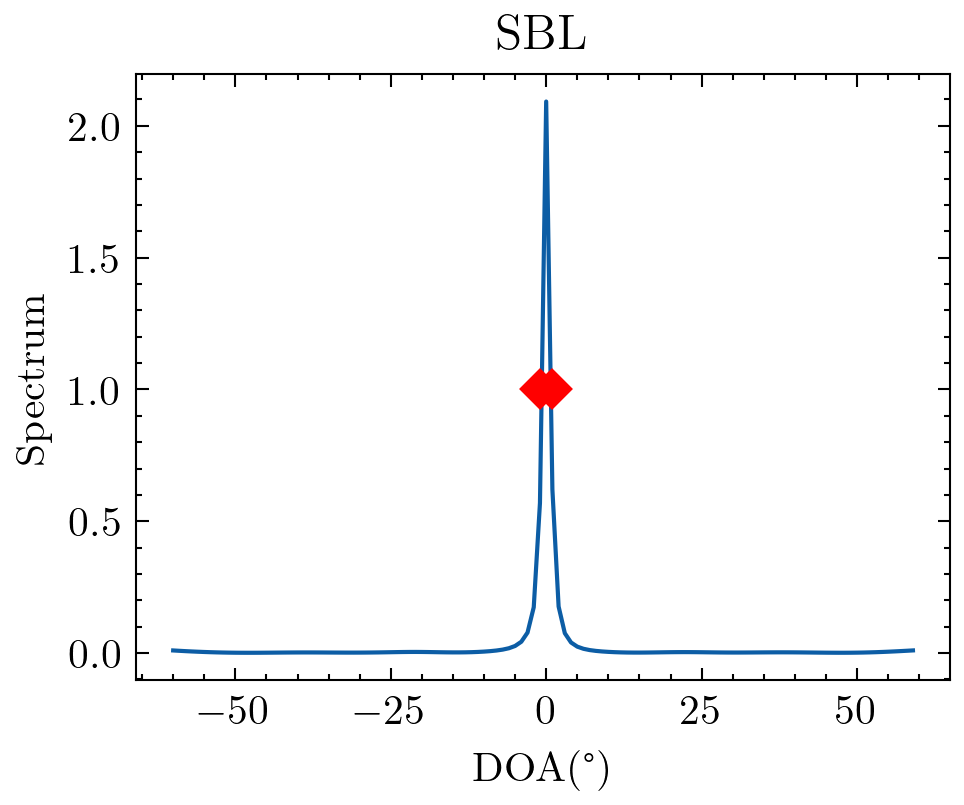

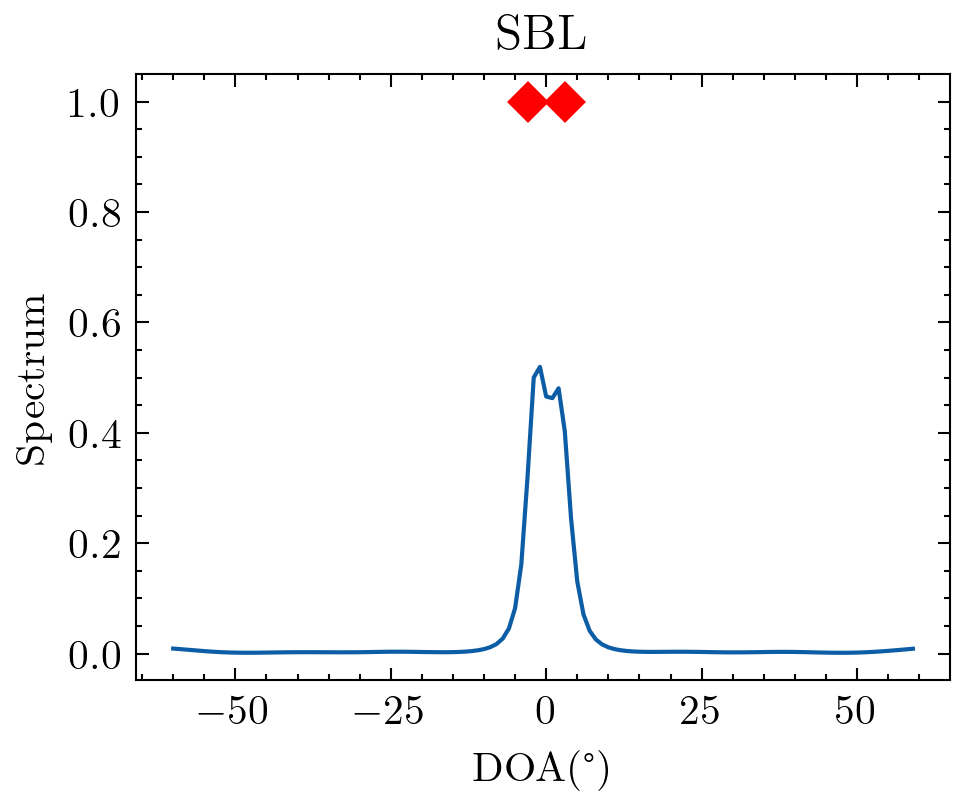

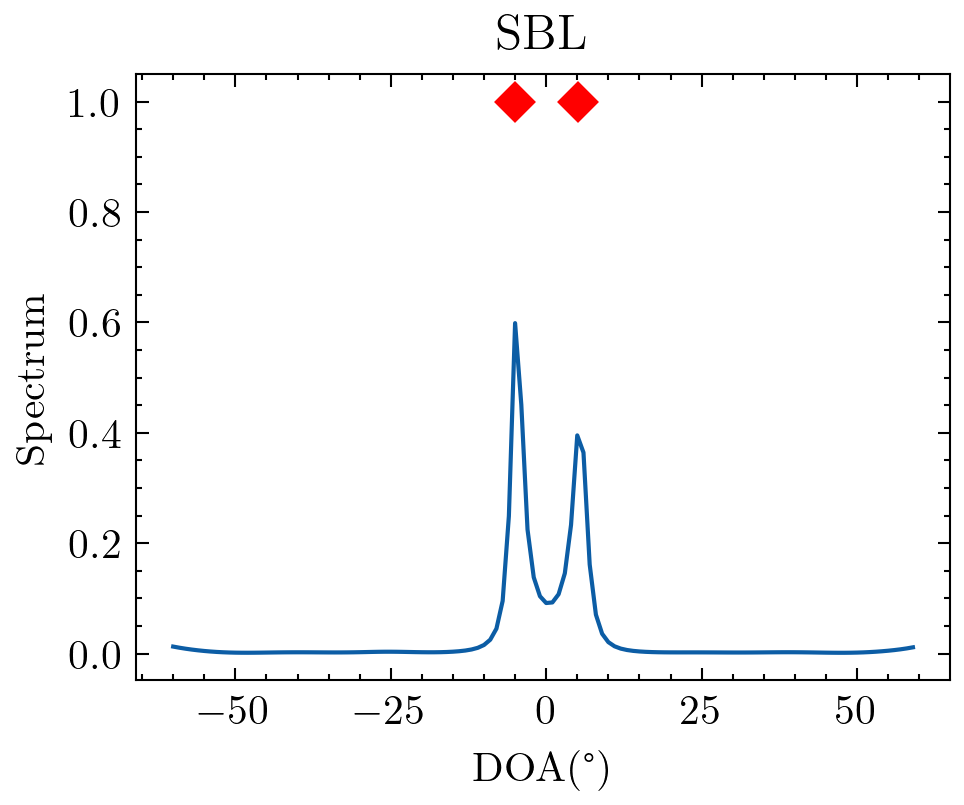

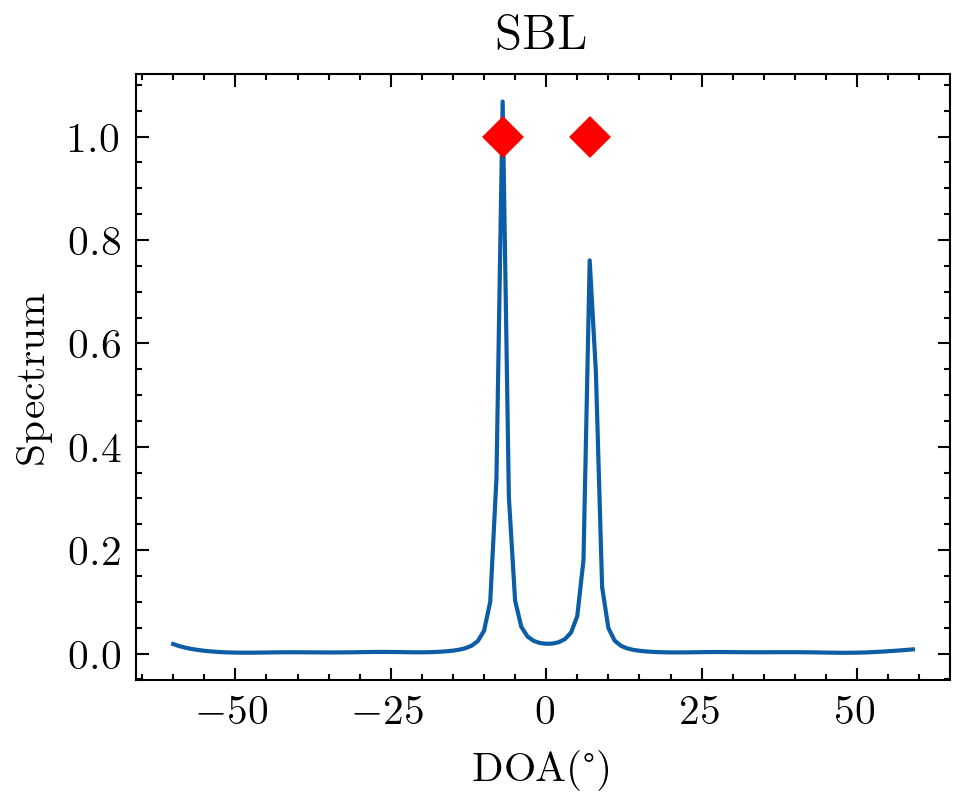

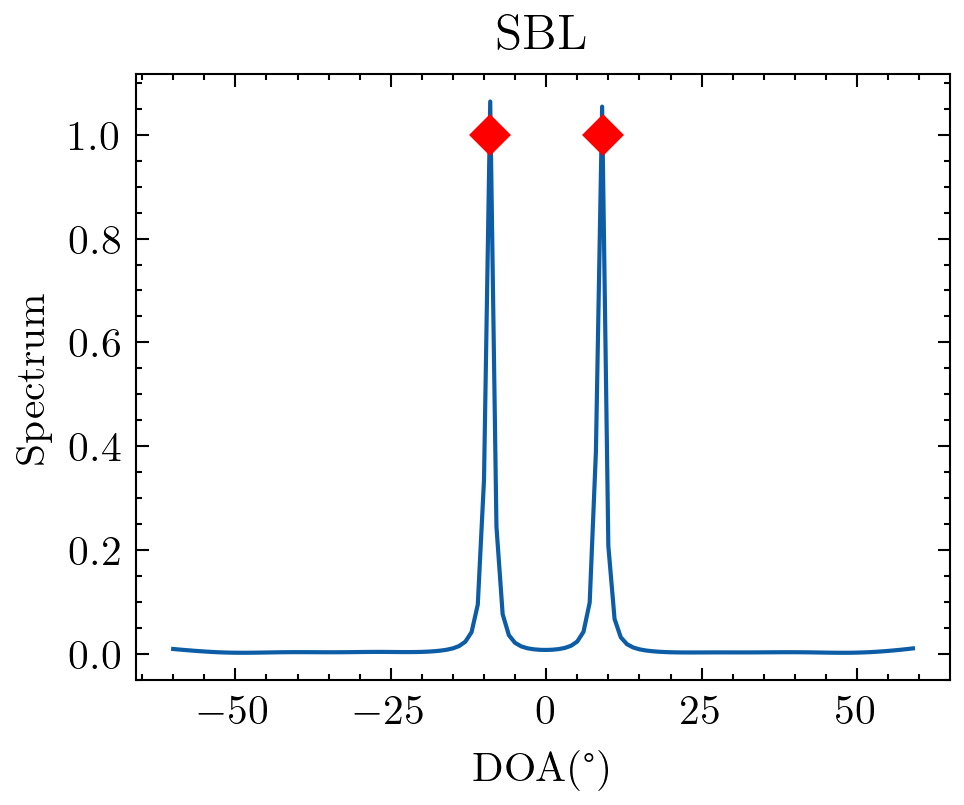

In [86]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = gamma[i,:]
        plt.figure()
        plt.title('SBL')
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/SBL/DOA'+str(i)+'.pdf')
        plt.show()